In [8]:
%pip install transformers datasets accelerate evaluate scikit-learn matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer

imdb = load_dataset("imdb")

imdb = imdb["train"].train_test_split(test_size=0.2, seed=42)
temp = imdb["train"].train_test_split(test_size=0.125, seed=42)
imdb = {
    "train": temp["train"], 
    "validation": temp["test"], 
    "test": imdb["test"], 
}

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

max_length = 256

def tokenize_imdb(example):
    return tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=max_length,
    )

tokenized_imdb = {}
for split in ["train", "validation", "test"]:
    tokenized_imdb[split] = imdb[split].map(
        tokenize_imdb,
        batched=True,
        remove_columns=["text"]
    )


In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from scipy.special import softmax
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
)

num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=num_labels)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = softmax(logits, axis=-1)
    preds = probs.argmax(axis=-1)

    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary"
    )
    roc = roc_auc_score(labels, probs[:, 1])

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc,
    }

training_args = TrainingArguments(
    output_dir="./imdb-distilbert",
    do_train=True,
    do_eval=True,     
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_imdb["train"],
    eval_dataset=tokenized_imdb["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

val_metrics = trainer.evaluate(tokenized_imdb["validation"])
print("Validation metrics:", val_metrics)

test_metrics = trainer.evaluate(tokenized_imdb["test"])
print("Test metrics:", test_metrics)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/hl/c7pd8_zd1qq_vz2203gnpk0m0000gn/T/ipykernel_52120/3174557767.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.343600
1000,0.275700
1500,0.186800
2000,0.189300
2500,0.137900
3000,0.109900


/Users/jasonlai150/Documents/GeorgiaTech/Y3S1/MATH 4210/Project Code/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/jasonlai150/Documents/GeorgiaTech/Y3S1/MATH 4210/Project Code/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/jasonlai150/Documents/GeorgiaTech/Y3S1/MATH 4210/Project Code/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation metrics: {'eval_loss': 0.36959177255630493, 'eval_accuracy': 0.9048, 'eval_precision': 0.9148936170212766, 'eval_recall': 0.8993028659953525, 'eval_f1': 0.90703125, 'eval_roc_auc': 0.9654216792594144, 'eval_runtime': 19.0674, 'eval_samples_per_second': 131.114, 'eval_steps_per_second': 4.143, 'epoch': 3.0}


/Users/jasonlai150/Documents/GeorgiaTech/Y3S1/MATH 4210/Project Code/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Test metrics: {'eval_loss': 0.3508628010749817, 'eval_accuracy': 0.908, 'eval_precision': 0.9199507389162561, 'eval_recall': 0.8942537909018355, 'eval_f1': 0.9069202751922298, 'eval_roc_auc': 0.9693471034393157, 'eval_runtime': 36.2326, 'eval_samples_per_second': 137.997, 'eval_steps_per_second': 4.333, 'epoch': 3.0}


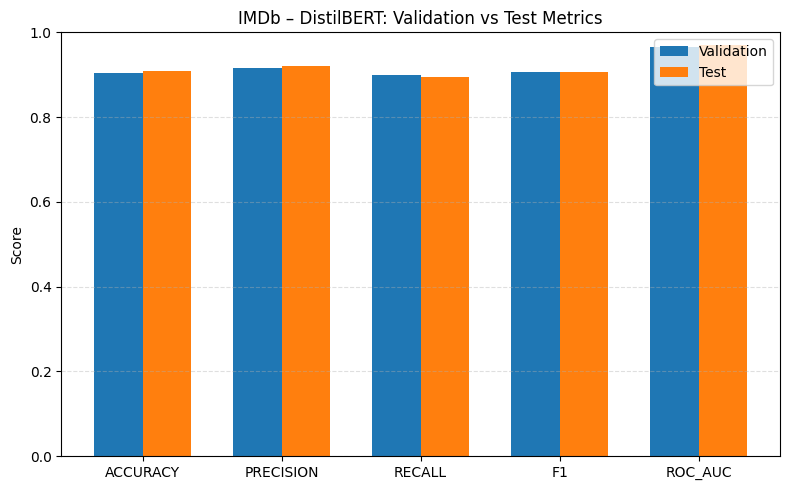

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metric_names = ["accuracy", "precision", "recall", "f1", "roc_auc"]

val_values = [val_metrics[f"eval_{m}"] for m in metric_names]
test_values = [test_metrics[f"eval_{m}"] for m in metric_names]

x = np.arange(len(metric_names)) 
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, val_values, width, label="Validation")
plt.bar(x + width/2, test_values, width, label="Test")

plt.xticks(x, [m.upper() for m in metric_names])
plt.ylabel("Score")
plt.title("IMDb – DistilBERT: Validation vs Test Metrics")
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


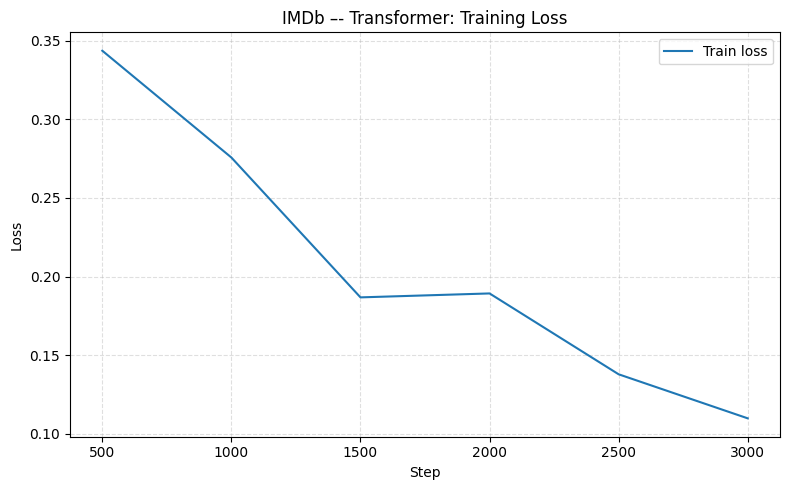

In [ ]:
log_history = trainer.state.log_history

train_steps = []
train_loss = []
eval_steps = []
eval_loss = []

for log in log_history:
    if "loss" in log and "epoch" in log:
        train_steps.append(log["step"])
        train_loss.append(log["loss"])
    if "eval_loss" in log:
        eval_steps.append(log["step"])
        eval_loss.append(log["eval_loss"])

plt.figure(figsize=(8, 5))
plt.plot(train_steps, train_loss, label="Train loss")

plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("IMDb –- Transformer: Training Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

/Users/jasonlai150/Documents/GeorgiaTech/Y3S1/MATH 4210/Project Code/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


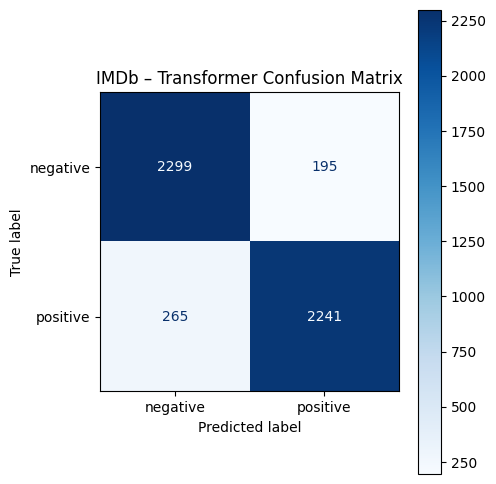

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

imdb_pred_output = trainer.predict(tokenized_imdb["test"])
logits = imdb_pred_output.predictions
y_true_imdb = imdb_pred_output.label_ids

y_pred_imdb = np.argmax(logits, axis=-1)

imdb_labels = ["negative", "positive"]

cm_imdb = confusion_matrix(y_true_imdb, y_pred_imdb)
disp_imdb = ConfusionMatrixDisplay(confusion_matrix=cm_imdb,display_labels=imdb_labels)

plt.figure(figsize=(5, 5))
disp_imdb.plot(values_format='d', cmap="Blues", ax=plt.gca())
plt.title("IMDb – Transformer Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()